# Background removal with SVD

## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip 
# "from moviepy.editor" or "from moviepy" depending on your moviepy version

In [2]:
pip show moviepy

Name: moviepy
Version: 1.0.3
Summary: Video editing with Python
Home-page: https://zulko.github.io/moviepy/
Author: Zulko 2017
Author-email: 
License: MIT License
Location: /Users/chenxuemei/anaconda3/lib/python3.11/site-packages
Requires: decorator, imageio, imageio-ffmpeg, numpy, numpy, proglog, requests, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


I have reverted back to moviepy version 1.0.3:
```
pip uninstall moviepy
pip install moviepy==1.0.3
```

## Adjust print() precisions
`suppress = True` means suppressing scientific notation.

In [3]:
np.set_printoptions(precision = 2, suppress = True)

## Useful matrix operations with numpy
- `A.T`: transpose of `A`
- `@`: matrix multiplication

## SVD

In [4]:
A = np.array([[-1,-3,-3,-1],
              [2.5,1.5,1.5,2.5],
              [-2,0,0,-2]])
A

array([[-1. , -3. , -3. , -1. ],
       [ 2.5,  1.5,  1.5,  2.5],
       [-2. ,  0. ,  0. , -2. ]])

Take the SVD of A. In Python, `np.linalg.svd` outputs U, S, and **V transpose**.

In [5]:
U, S, Vt = np.linalg.svd(A)

In [6]:
U

array([[ 0.67, -0.67,  0.33],
       [-0.67, -0.33,  0.67],
       [ 0.33,  0.67,  0.67]])

S stores the singular values of A, and `len(S)` is the smaller of the two dimensions of A.

In [7]:
S

array([6., 3., 0.])

In [8]:
V = Vt.T
V

array([[-0.5 , -0.5 , -0.69, -0.13],
       [-0.5 ,  0.5 , -0.13,  0.69],
       [-0.5 ,  0.5 ,  0.13, -0.69],
       [-0.5 , -0.5 ,  0.69,  0.13]])

### check that both U and V are orthogonal matrices

In [9]:
print(U.T@U)
print(V.T@V)

[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
[[ 1.  0. -0.  0.]
 [ 0.  1.  0.  0.]
 [-0.  0.  1. -0.]
 [ 0.  0. -0.  1.]]


### Check that $A = U\Sigma V^T$

In [10]:
Sigma = np.zeros([3,4])
Sigma[:3,:3] = np.diag(S)
Sigma

array([[6., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 0., 0.]])

In [11]:
np.abs(A - U@Sigma@V.T)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

## Working with a video

### Read a video

In [14]:
video = VideoFileClip("../data/vid_background.avi")

In [15]:
video.fps, video.duration, video.w, video.h

(7.0, 113.57, 320, 240)

In [16]:
# shorter video, the first 50 seconds
vid = video.subclip(0, 50)

A video is a sequence of images.

In [17]:
vid.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### See the first frame of this video

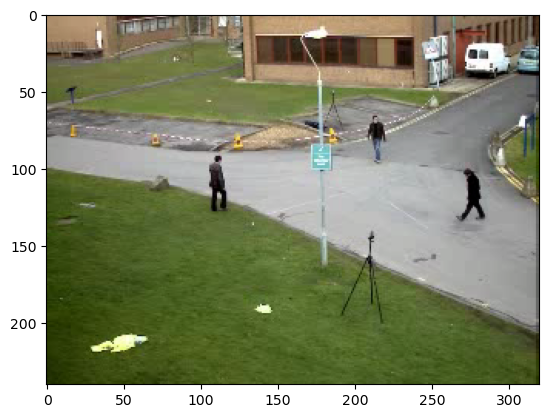

In [18]:
plt.imshow(vid.get_frame(0));

In [19]:
vid.get_frame(0).shape

(240, 320, 3)

This is a colored image.

Usually a colored image has 3 channels (RGB), making each frame a $240 \times 320 \times 3$ array.

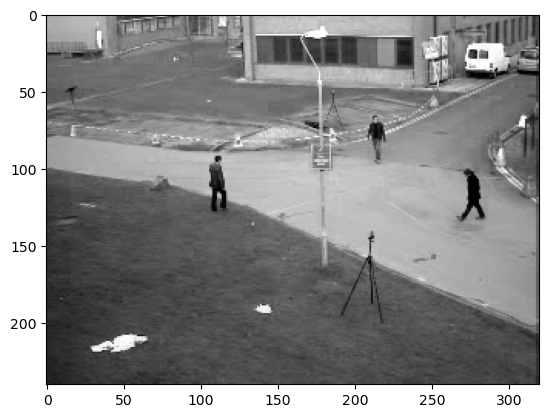

In [20]:
# showing the R channel
plt.imshow(video.get_frame(0)[:,:,0], cmap = 'gray');

### Color to grayscale
we can turn this colored image to a grayscale one by averaging all 3 channels

In [21]:
vid_0_gray = video.get_frame(0)[:,:,0]/3 + video.get_frame(0)[:,:,1]/3 + video.get_frame(0)[:,:,2]/3

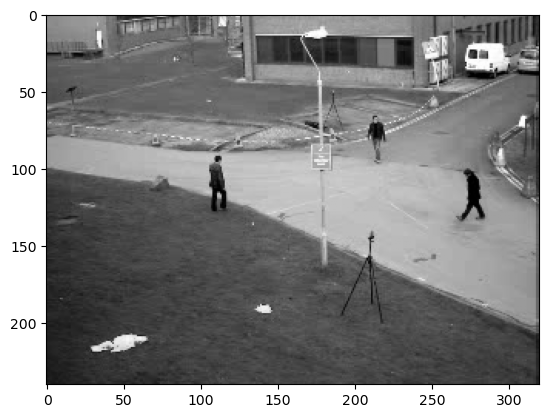

In [22]:
plt.imshow(vid_0_gray, cmap='gray');

In [23]:
vid_array = np.array(list(vid.iter_frames()))
vid_array.shape

(350, 240, 320, 3)

In [24]:
def rgb2gray(vid_c):
    '''
    turn a colored video vid_c into a gray scale video
    input: vid_c is 4d array: (n_frames, h, w, 3)
    output vid_g is 3d array: (n_frames, h, w)
    '''
    return np.sum(vid_c*np.ones(3)/3, axis = 3)

In [25]:
vid_gray_array = rgb2gray(vid_array)

In [26]:
vid_gray_array.shape

(350, 240, 320)

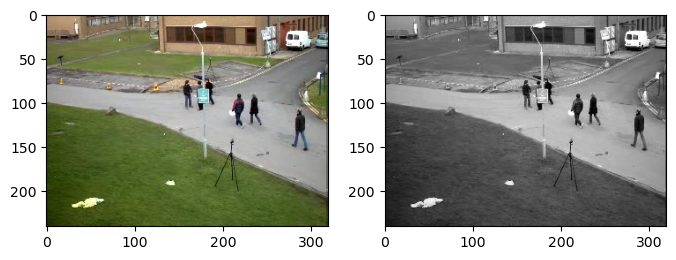

In [27]:
frame_idx = 50;
fig, axs1 = plt.subplots(1, 2, figsize=(8,8)) 
axs1[0].imshow(vid_array[frame_idx,...]);
axs1[1].imshow(vid_gray_array[frame_idx,...], cmap='gray');

## We will be working with `vid_gray_array` from here on

## Vectorization of one frame (a gray scale image)
This is to turn any matrix into one column vector. Usually it will be vectorized along the columns, as indicated below

$\begin{bmatrix}a&b&c\\x&y&z\\d&e&f\end{bmatrix}\longrightarrow\begin{bmatrix}a\\x\\d\\b\\y\\e\\c\\z\\f\end{bmatrix}$

In [28]:
a = np.random.rand(2,3)
print('a:\n',a)
print('python default is to vectorize rowwise:\n', a.reshape([6,1]))
print('flatten() works to:\n', a.flatten())
print('use "order = \'F\'" for columnwise reshape\n',a.reshape([6,1], order = 'F'))

a:
 [[0.83 0.77 0.81]
 [0.94 0.2  0.41]]
python default is to vectorize rowwise:
 [[0.83]
 [0.77]
 [0.81]
 [0.94]
 [0.2 ]
 [0.41]]
flatten() works to:
 [0.83 0.77 0.81 0.94 0.2  0.41]
use "order = 'F'" for columnwise reshape
 [[0.83]
 [0.94]
 [0.77]
 [0.2 ]
 [0.81]
 [0.41]]


## Turn the grayscale video into ONE matrix
For each frame, vectorize it

`vid_gray_array` ($f \times m\times n$) $\longrightarrow$ `vid_gray_mat` ($f \times mn$)

In [29]:
m = vid_gray_array.shape[1]
n = vid_gray_array.shape[2]
vid_gray_mat = vid_gray_array.reshape([-1, m*n])

In [30]:
vid_gray_mat.shape

(350, 76800)

### sanity check

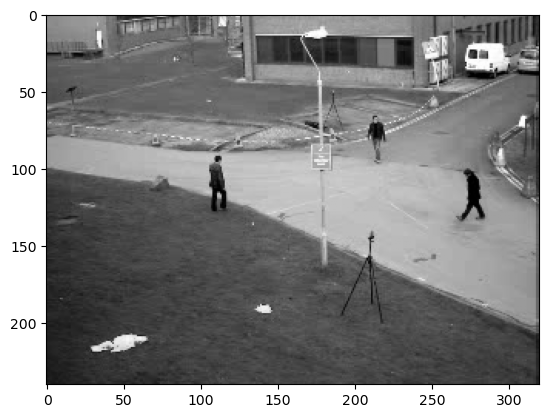

In [31]:
plt.imshow(vid_gray_mat[0,:].reshape([m,n]), cmap = 'gray');

### Take a transpose so that ith COLUMN of `vid_gray_mat` is ith frame of the video.

In [32]:
vid_gray_mat = vid_gray_mat.T

### take a look at this video matrix

Take the SVD of this video matrix.

In [33]:
U_v, S_v, Vt_v = np.linalg.svd(vid_gray_mat, full_matrices=False) 

In [34]:
print(U_v.shape)
print(Vt_v.shape)

(76800, 350)
(350, 350)


In [35]:
S_v[:10]

array([627573.74,  19847.2 ,  16831.31,  15639.76,  13616.08,  13415.44,
        13187.56,  12588.66,  12406.42,  11559.61])

### What will this matrix be like if it is all background?

In [ ]:
# best rank-1 approximation

In [ ]:
M = vid_gray_mat

In [ ]:
#fig, axs = plt.subplots(1, 2, figsize=(12,6)) 
#axs[0].imshow();
#axs[1].imshow();

In [ ]:
# Show the moving people